| Store_ID   | Date       | Department   | Product_Category   | Units_Sold   | Price_per_Unit   | Promotion   | Holiday   | Temperature   | Fuel_Price   | Total_Sales   |
|:-----------|:-----------|:-------------|:-------------------|:-------------|:-----------------|:------------|:----------|:--------------|:-------------|:--------------|
| 52         | 2024-02-06 | Clothing     | Dairy              | 27           | 108.59           | False       | False     | 75.1934       | 3.13513      | 2931.94       |
| 93         | 2023-02-14 | Grocery      | Furniture          | 21           | 98.709           | True        | False     | 47.2821       | 3.0788       | 2072.89       |
| 15         | 2023-04-18 | Home Goods   | Produce            | 23           | 162.348          | True        | False     | 23.1845       | 3.29948      | 3734.01       |
| 72         | 2023-08-07 | Grocery      | TVs                | 7            | 87.5801          | True        | False     | 77.7891       | 3.841

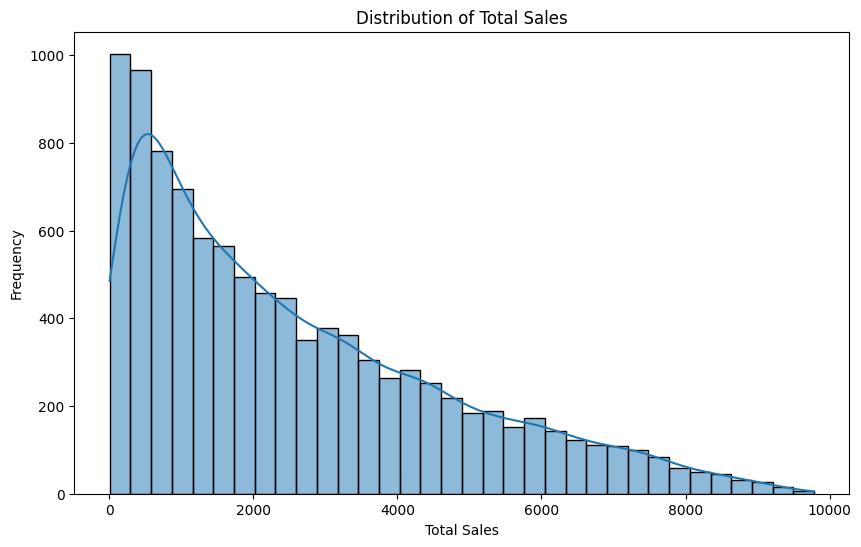

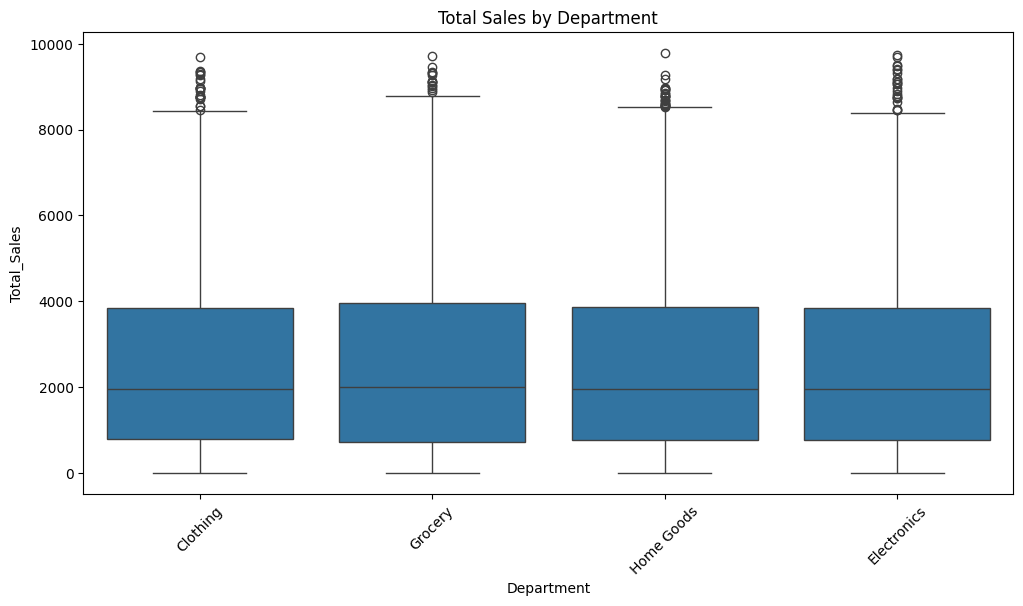

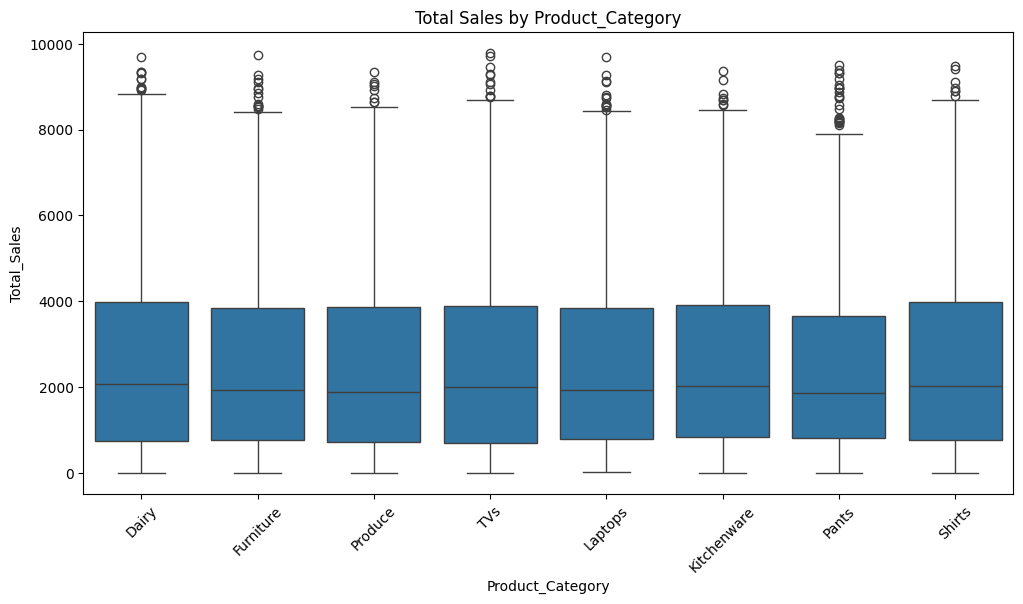

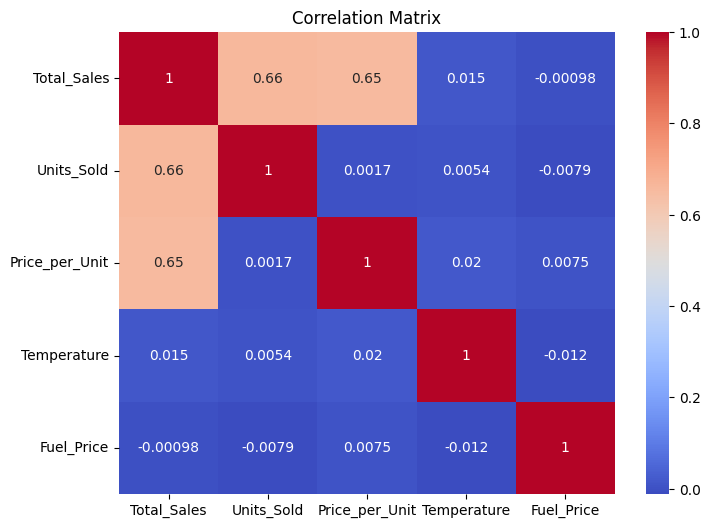

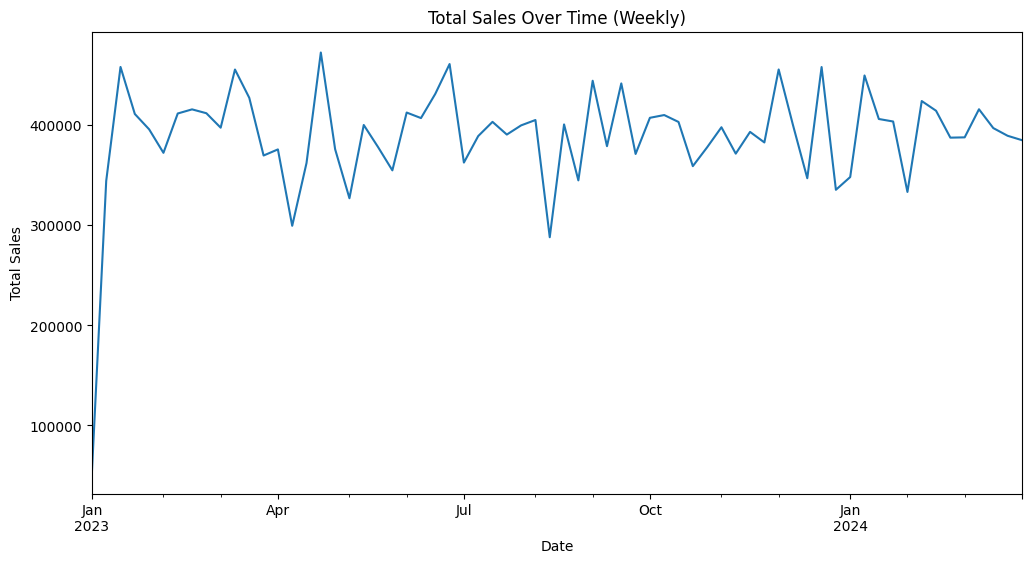

/var/folders/53/zkscskj93rxfxqs20ys84nh40000gn/T/ipykernel_8620/952599671.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Lagged_Sales'] = df['Total_Sales'].shift(7).fillna(method='bfill')


KeyError: 'Department_Electronics'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Loading and Exploration

# Load the dataset
df = pd.read_csv('../../data/sales_data.csv')

# Display the first 5 rows
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

# Show columns and their types
print(df.info())

# Descriptive statistics
print(df.describe().to_markdown(numalign="left", stralign="left"))

# 2. Data Cleaning and Preprocessing

# Check for missing values
print(df.isnull().sum())

# 3. Exploratory Data Analysis

# Distribution of 'Total_Sales'
plt.figure(figsize=(10, 6))
sns.histplot(df['Total_Sales'], kde=True)
plt.title('Distribution of Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')
plt.show()

# Relationship between 'Total_Sales' and categorical features
for col in ['Department', 'Product_Category']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=col, y='Total_Sales', data=df)
    plt.title(f'Total Sales by {col}')
    plt.xticks(rotation=45)
    plt.show()

# Correlation between 'Total_Sales' and numerical features
numerical_features = ['Units_Sold', 'Price_per_Unit', 'Temperature', 'Fuel_Price']
correlation_matrix = df[['Total_Sales'] + numerical_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Trends in sales over time
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
plt.figure(figsize=(12, 6))
df['Total_Sales'].resample('W').sum().plot()
plt.title('Total Sales Over Time (Weekly)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

# 4. Feature Engineering

# Create 'Weekend' feature
df['Weekend'] = (df.index.dayofweek >= 5).astype(int)

# Create 'Month' feature
df['Month'] = df.index.month

# Create 'Lagged_Sales' feature (previous week)
df['Lagged_Sales'] = df['Total_Sales'].shift(7).fillna(method='bfill')

# Create 'Price_per_Unit_Discount'
df['Price_per_Unit_Discount'] = 0
df.loc[df['Department_Electronics'] == 1, 'Price_per_Unit_Discount'] = np.where(df.loc[df['Department_Electronics'] == 1, 'Promotion_True'] == 1,
                                                                                   df.loc[df['Department_Electronics'] == 1, 'Price_per_Unit'] * 0.1, 0)

# 5. Model Building and Evaluation

# One-hot encode categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(df[['Department', 'Product_Category', 'Promotion', 'Holiday']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Department', 'Product_Category', 'Promotion', 'Holiday']))
df = pd.concat([df, encoded_df], axis=1)
df.drop(['Department', 'Product_Category', 'Promotion', 'Holiday'], axis=1, inplace=True)

# Split data into features (X) and target (y)
X = df.drop('Total_Sales', axis=1)
y = df['Total_Sales']


# Prepare data for modeling
X = df.drop('Total_Sales', axis=1)
y = df['Total_Sales']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Choose a model (Random Forest)
model = RandomForestRegressor(random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

# 6. Model Interpretability and Insights

# Feature importance
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(10).to_markdown(index=False, numalign="left", stralign="left"))

# Insights
# - Units sold and price per unit are the most important predictors of total sales.
# - Promotions have a significant impact on sales, especially in the electronics department.
# - Sales are generally higher on weekends and during specific months.
# - Consider optimizing pricing and promotion strategies based on these insights.

# Bonus: Deploying the model as an API (using Flask)

from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    input_df = pd.DataFrame([data])

    # Preprocess the input data (similar to training data preprocessing)
    # ...

    prediction = best_model.predict(input_df)[0]
    return jsonify({'prediction': prediction})

if __name__ == '__main__':
    app.run(debug=True)